Command line tutorial
=====================

This tutorial will walk you through the usage of the ``lib5c`` command-line
tools.

Follow along in Google colab
-----------------

You can run and modify the cells in this notebook tutorial live using Google colaboratory by clicking the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thomasgilgenast/lib5c-tutorials/blob/master/commandline_tutorial.ipynb)

To simply have all the cells run automatically, click `Runtime > Run all` in the colab toolbar.

Make sure `lib5c` is installed
------------------------------

Inside a fresh virtual environment, run

In [1]:
!pip install -q lib5c
!lib5c -v

lib5c version 0.6.0a1


Make a directory and get data
-----------------------------

If you haven't completed the [pipeline tutorial](pipeline_tutorial.ipynb) yet,
make a directory for the tutorial:

```
$ mkdir lib5c-tutorial
$ cd lib5c-tutorial
```

and prepare the example data in `lib5c-tutorial/input` as shown in the
[pipeline tutorial](pipeline_tutorial.ipynb).

In [2]:
!python -m lib5c.util.demo_data

Note for Docker image users
---------------------------

If you are using `lib5c` from the Docker image, run:

    $ docker run -it -v <full path to lib5c-tutorial>:/lib5c-tutorial creminslab/lib5c:latest
    root@<container_id>:/# cd /lib5c-tutorial

and continue running all tutorial commands in this shell.

Trimming low-quality primers
----------------------------

We will first trim away low-quality primers by running

In [3]:
!lib5c trim -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -t trimmed/%s.counts trimmed/primers_trimmed.bed 'input/*.counts'

creating directory trimmed


Normalization
-------------

For this tutorial, we will first use Knight-Ruiz matrix balancing to correct our
data for primer effects by running

In [4]:
!lib5c kr trimmed/pNPC_Rep2.counts kr/pNPC_Rep2.counts

loading counts


kr balancing


writing counts
creating directory kr


`lib5c kr` specifies that the specific subcommand we want is `kr`, the
subcommand for Knight-Ruiz balancing. To see all the available subcommands, you
can run

In [5]:
!lib5c -h

                        sub-commands
    pipeline            run entire pipeline
    hic-extract         extract chunks from Hi-C data
    trim                primer and countsfile trimming
    outliers            remove high spatial outliers
    remove              remove low-count primer-primer pairs
    qnorm               quantile normalization
    express             express normalization
    kr                  knight-ruiz matrix balancing normalization
    spline              spline normalization
    determine-bins      create binfiles from primerfiles
    bin                 bin fragment-level counts
    smooth              smooth counts
    expected            compute expected models
    variance            estimate variances from obs values and exp models
    pvalues             call pvalues for interactions
    threshold           threshold p-values
    qvalues             perform multiple testing correction
    interaction-score   convert p-values to interaction scores
    

To see detailed help for the `kr` subcommand, you can run

In [6]:
!lib5c kr -h

usage: lib5c kr [-h] [-p PRIMERFILE] [-H] [-B] [-i MAX_ITERATIONS]
                [-s IMPUTATION_SIZE]
                infile outfile

positional arguments:
  infile                Input countsfile.
  outfile               Output countsfile.

optional arguments:
  -h, --help            show this help message and exit
  -p PRIMERFILE, --primerfile PRIMERFILE
                        Primer file or bin file to use. If this flag is not
                        present, a .bed file will be searched for based on the
                        locations of the input files.
  -H, --hang            If multiple input files are specified, this flag will
                        cause the terminal to hang until all input files have
                        finished processing.
  -B, --output_bias     If this flag is present, the bias vectors will be
                        written to .bias files located next to the output
                        .counts files.
  -i MAX_ITERATIONS, --max_iterations MAX_

The two required positional command line arguments for `lib5c kr` are
`infile` (the countsfile we want to balance) and `outfile` (where to write
the balanced countsfile).

### Processing multiple input files

If we want to process a lot of countsfiles, we can use a pattern like this

In [7]:
!lib5c kr 'trimmed/*.counts' kr/%s.counts

lib5c kr  trimmed/v65_Rep1.counts 'kr/v65_Rep1.counts' --max_iterations '3000' --imputation_size '0'


loading counts


kr balancing


writing counts


lib5c kr  trimmed/pNPC_Rep1.counts 'kr/pNPC_Rep1.counts' --max_iterations '3000' --imputation_size '0'


loading counts


kr balancing


writing counts


lib5c kr  trimmed/v65_Rep2.counts 'kr/v65_Rep2.counts' --max_iterations '3000' --imputation_size '0'


loading counts


kr balancing


writing counts


lib5c kr  trimmed/pNPC_Rep2.counts 'kr/pNPC_Rep2.counts' --max_iterations '3000' --imputation_size '0'


loading counts


kr balancing


writing counts


Here instead of a single `infile`, we have put in a glob-expandable pattern
that will match all the countsfiles in the `input` directory. We have to quote
this pattern to prevent the shell from expanding it. If we are processing
multiple input countsfiles, then we expect multiple countsfiles as the output.
To specify this easily, we include `%s` in the `outfile`, which will be
replaced with the replicate name (derived automatically from the input
filenames).

If you're running this in a cluster environment with the LSF (aka `bsub`) job
scheduler available, you can install the `bsub` Python package via

    $ pip install bsub

and then all the input files will be processed in parallel via `bsub`.

If you aren't using the LSF job scheduler, you can still specify multiple input
files, but they will be processed in series.

Plotting heatmaps
-----------------

Let's take a look at the countsfiles we just generated.

One way to visualize countsfiles is to plot heatmaps of them. To do this, we can
run

In [8]:
!lib5c plot heatmap -p trimmed/primers_trimmed.bed --region Sox2 kr/pNPC_Rep2.counts kr/pNPC_Rep2_Sox2.png

loading counts


preparing to plot
plotting


The resulting image should look something like this

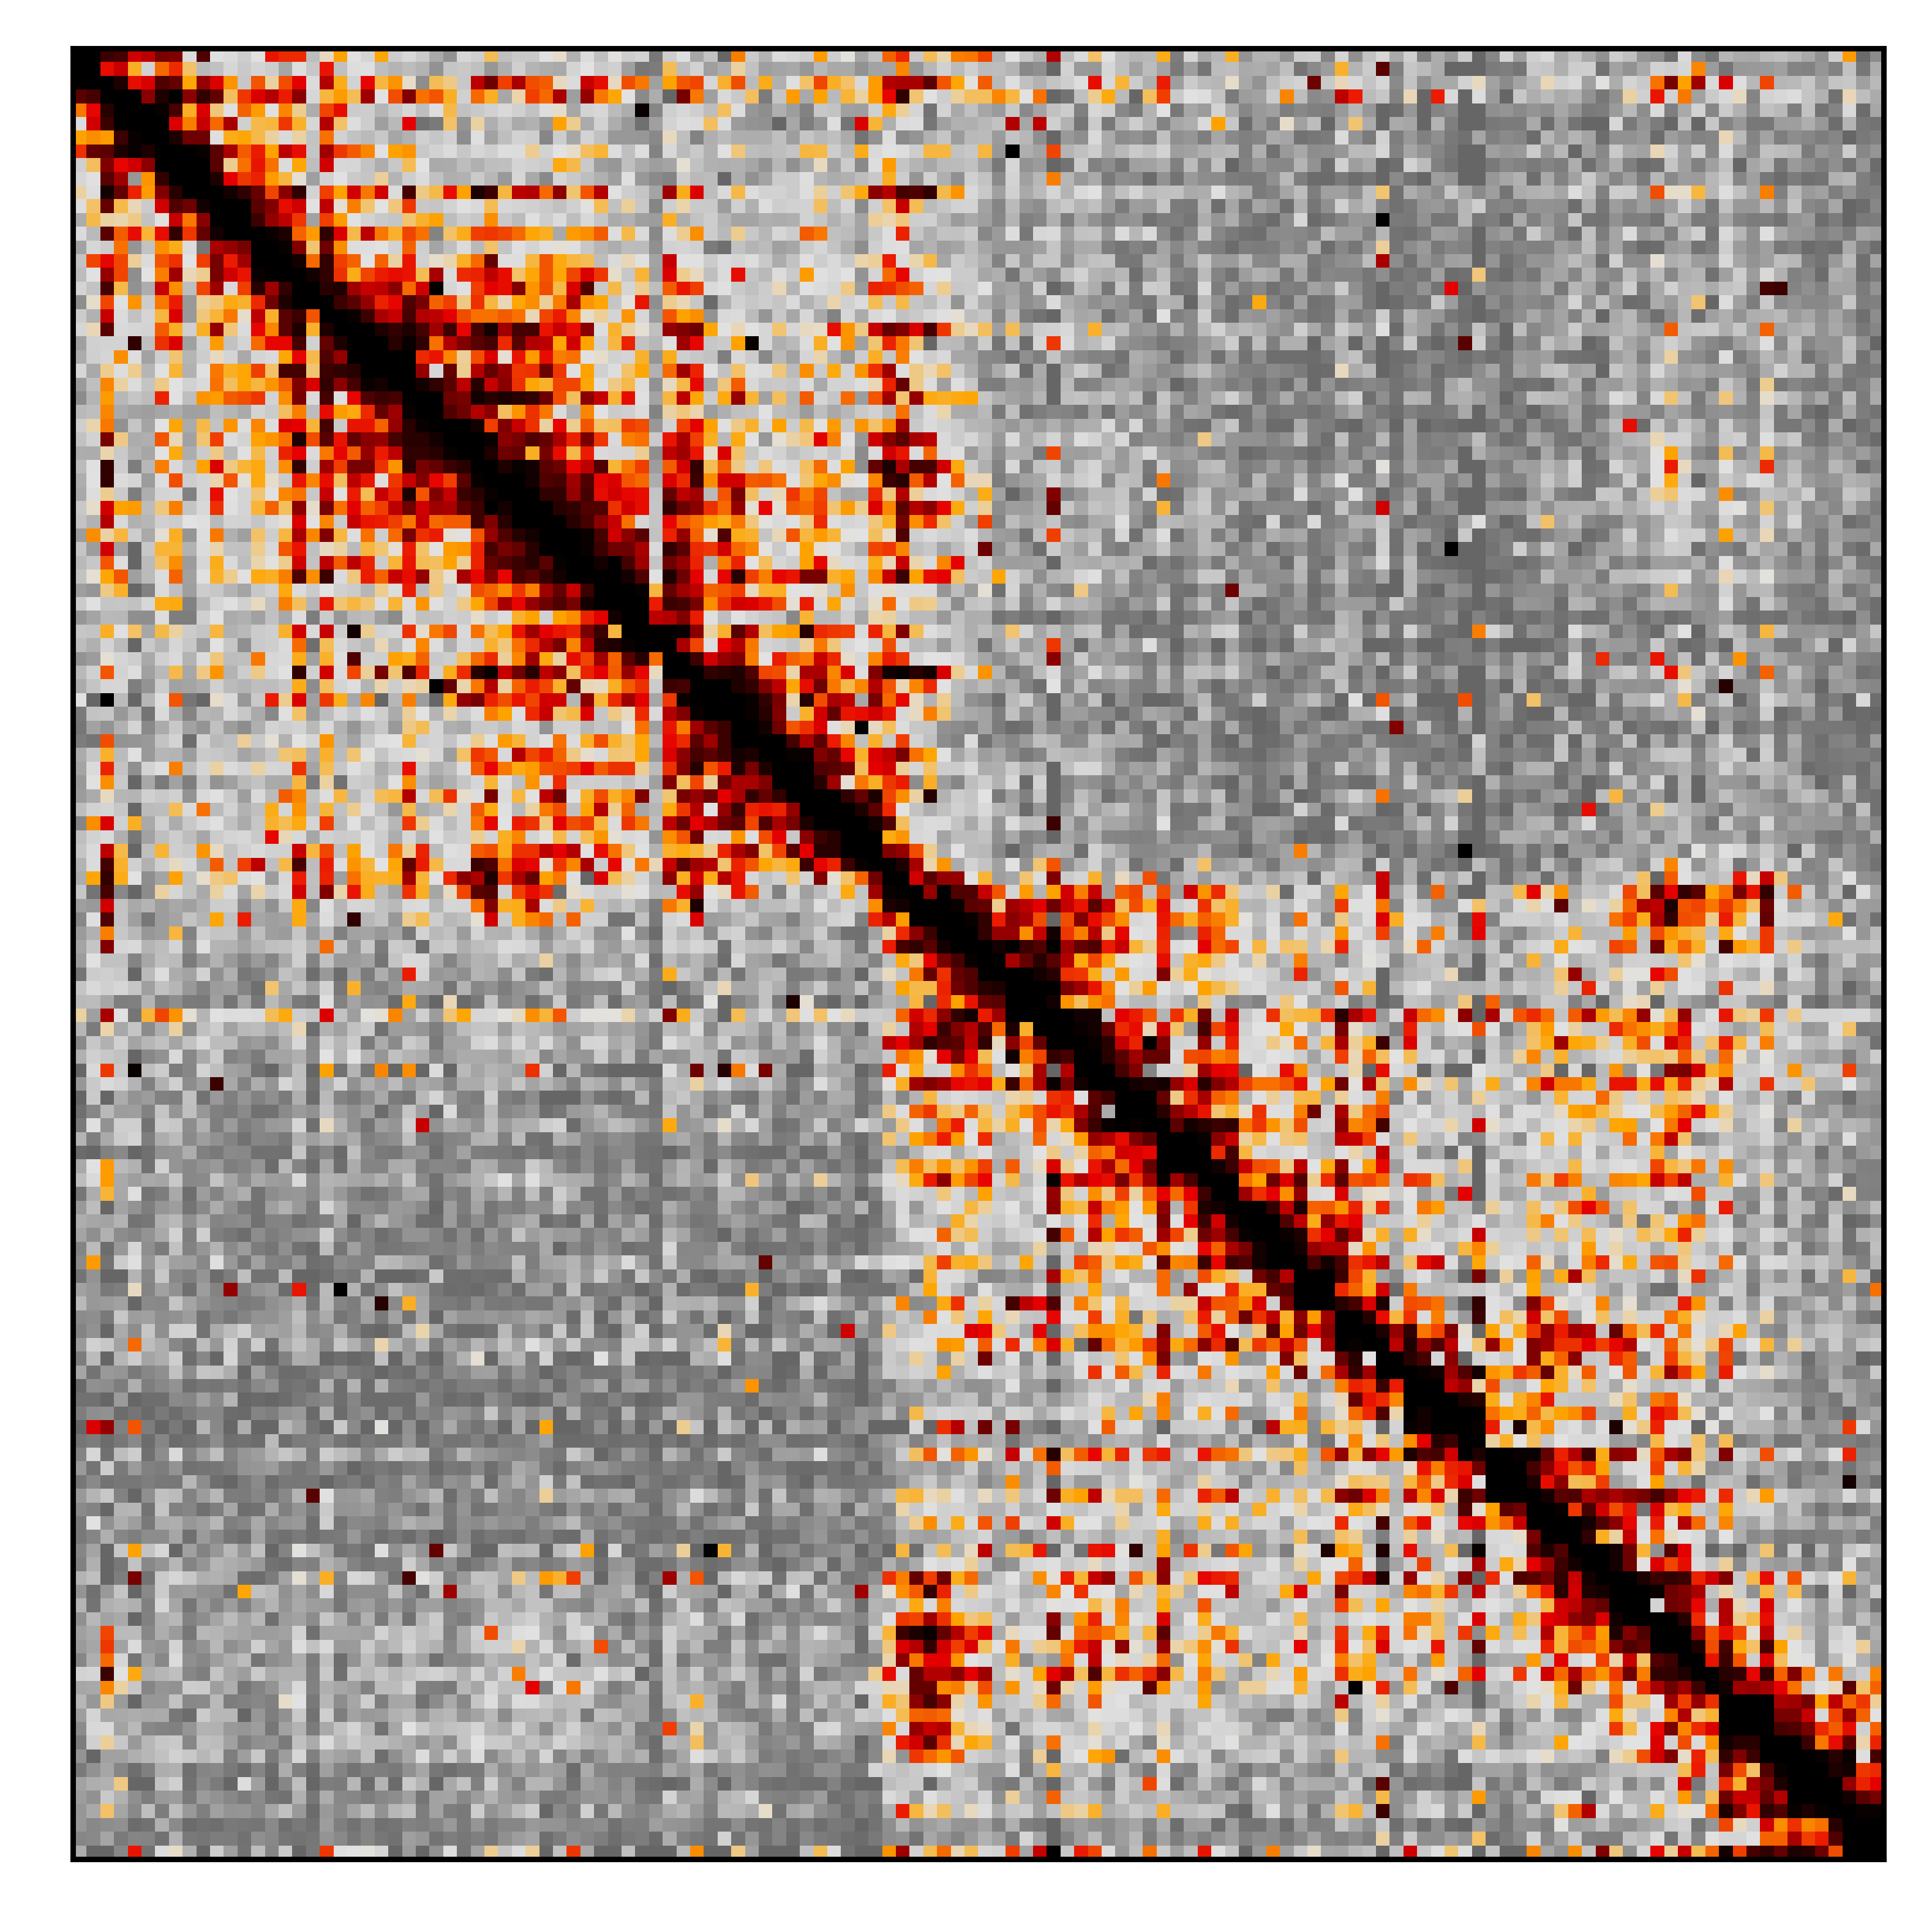

In [9]:
from IPython.display import Image
Image(filename='kr/pNPC_Rep2_Sox2.png', width=400)

The `lib5c plot heatmap` subcommand is a lot like the `lib5c kr` subcommand.
In fact, most `lib5c` subcommands work in almost exactly the same way, so
learning to use one can help you understand the others.

### Specifying a primerfile/binfile with `-p/--primerfile`


Almost every `lib5c` subcommand that takes countsfiles as its input also
requires a primerfile or a bedfile that it uses to make sure the countsfiles get
parsed correctly. This is accomplished with the `-p` flag. We didn't have to
use the `-p` flag in the `lib5c kr` example above because the primerfile we
wanted to use was already in the same directory as the countsfiles, so `lib5c`
was able to find it automatically. In general though, we might be trying to
process countsfiles that are separated (directory-wise) from the primerfile that
describes their genomic loci, in which case we would have to use the `-p` flag
as shown above.

### Multiple output files (one per region)

Some `lib5c` subcommands generate multiple output files (typically one per region). To create
an output file for only one region, use the `--region` (shorter form `-r`)
as shown above. Alternatively, if we want to generate output for all regions, we
can skip the `-r/--region` flag and include a `%r` in the `outfile`
instead, which will be replaced with the region name. Combining this with the
"multiple input files" idea from above, we can write something like

In [10]:
!lib5c plot heatmap -p trimmed/primers_trimmed.bed 'kr/*.counts' kr/%s_%r.png

lib5c plot heatmap  --primerfile 'trimmed/primers_trimmed.bed' --level 'auto' kr/v65_Rep1.counts 'kr/v65_Rep1_%r.png' --colormap 'obs' --log_base 'None' --pseudocount '1.0'


loading counts


preparing to plot


plotting


lib5c plot heatmap  --primerfile 'trimmed/primers_trimmed.bed' --level 'auto' kr/pNPC_Rep1.counts 'kr/pNPC_Rep1_%r.png' --colormap 'obs' --log_base 'None' --pseudocount '1.0'


loading counts


preparing to plot


plotting


lib5c plot heatmap  --primerfile 'trimmed/primers_trimmed.bed' --level 'auto' kr/v65_Rep2.counts 'kr/v65_Rep2_%r.png' --colormap 'obs' --log_base 'None' --pseudocount '1.0'


loading counts


preparing to plot


plotting


lib5c plot heatmap  --primerfile 'trimmed/primers_trimmed.bed' --level 'auto' kr/pNPC_Rep2.counts 'kr/pNPC_Rep2_%r.png' --colormap 'obs' --log_base 'None' --pseudocount '1.0'


loading counts


preparing to plot


plotting


Binning
-------

Let's bin our Knight-Ruiz balanced data!

Before we do this, we need to generate some bins to tile our 5C regions. To make 8 kb wide bins, we run

In [11]:
!lib5c determine-bins -w 8000 trimmed/primers_trimmed.bed bedfiles/8kb_bins.bed

The `-w/--bin_width` flag specifies the width of each bin in base pairs, and
`bedfiles/8kb_bins.bed` specifies the name of the newly-created bin bedfile.

Now that we have a bin bedfile describing the bins, we can figure out what the
counts values for each bin should be by running

In [12]:
!lib5c bin -w 24000 -p trimmed/primers_trimmed.bed -b bedfiles/8kb_bins.bed kr/pNPC_Rep2.counts binned/pNPC_Rep2.counts

creating directory binned


Notice that the `lib5c bin` subcommand needs both a primerfile (specified with
`-p`) and a bin bedfile (specified with `-b`). It needs the primerfile to
parse the input files, but it also needs a bin bedfile to know where the bins
should be and to write the output files. The last two arguments are just the
input file and the output file, just like in the previous subcommands.

We can plot a heatmap of our binned data by running

In [13]:
!lib5c plot heatmap -p bedfiles/8kb_bins.bed -r Sox2 -R -g mm9 binned/pNPC_Rep2.counts binned/pNPC_Rep2_Sox2.png

loading counts


preparing to plot
plotting


The result should look something like this

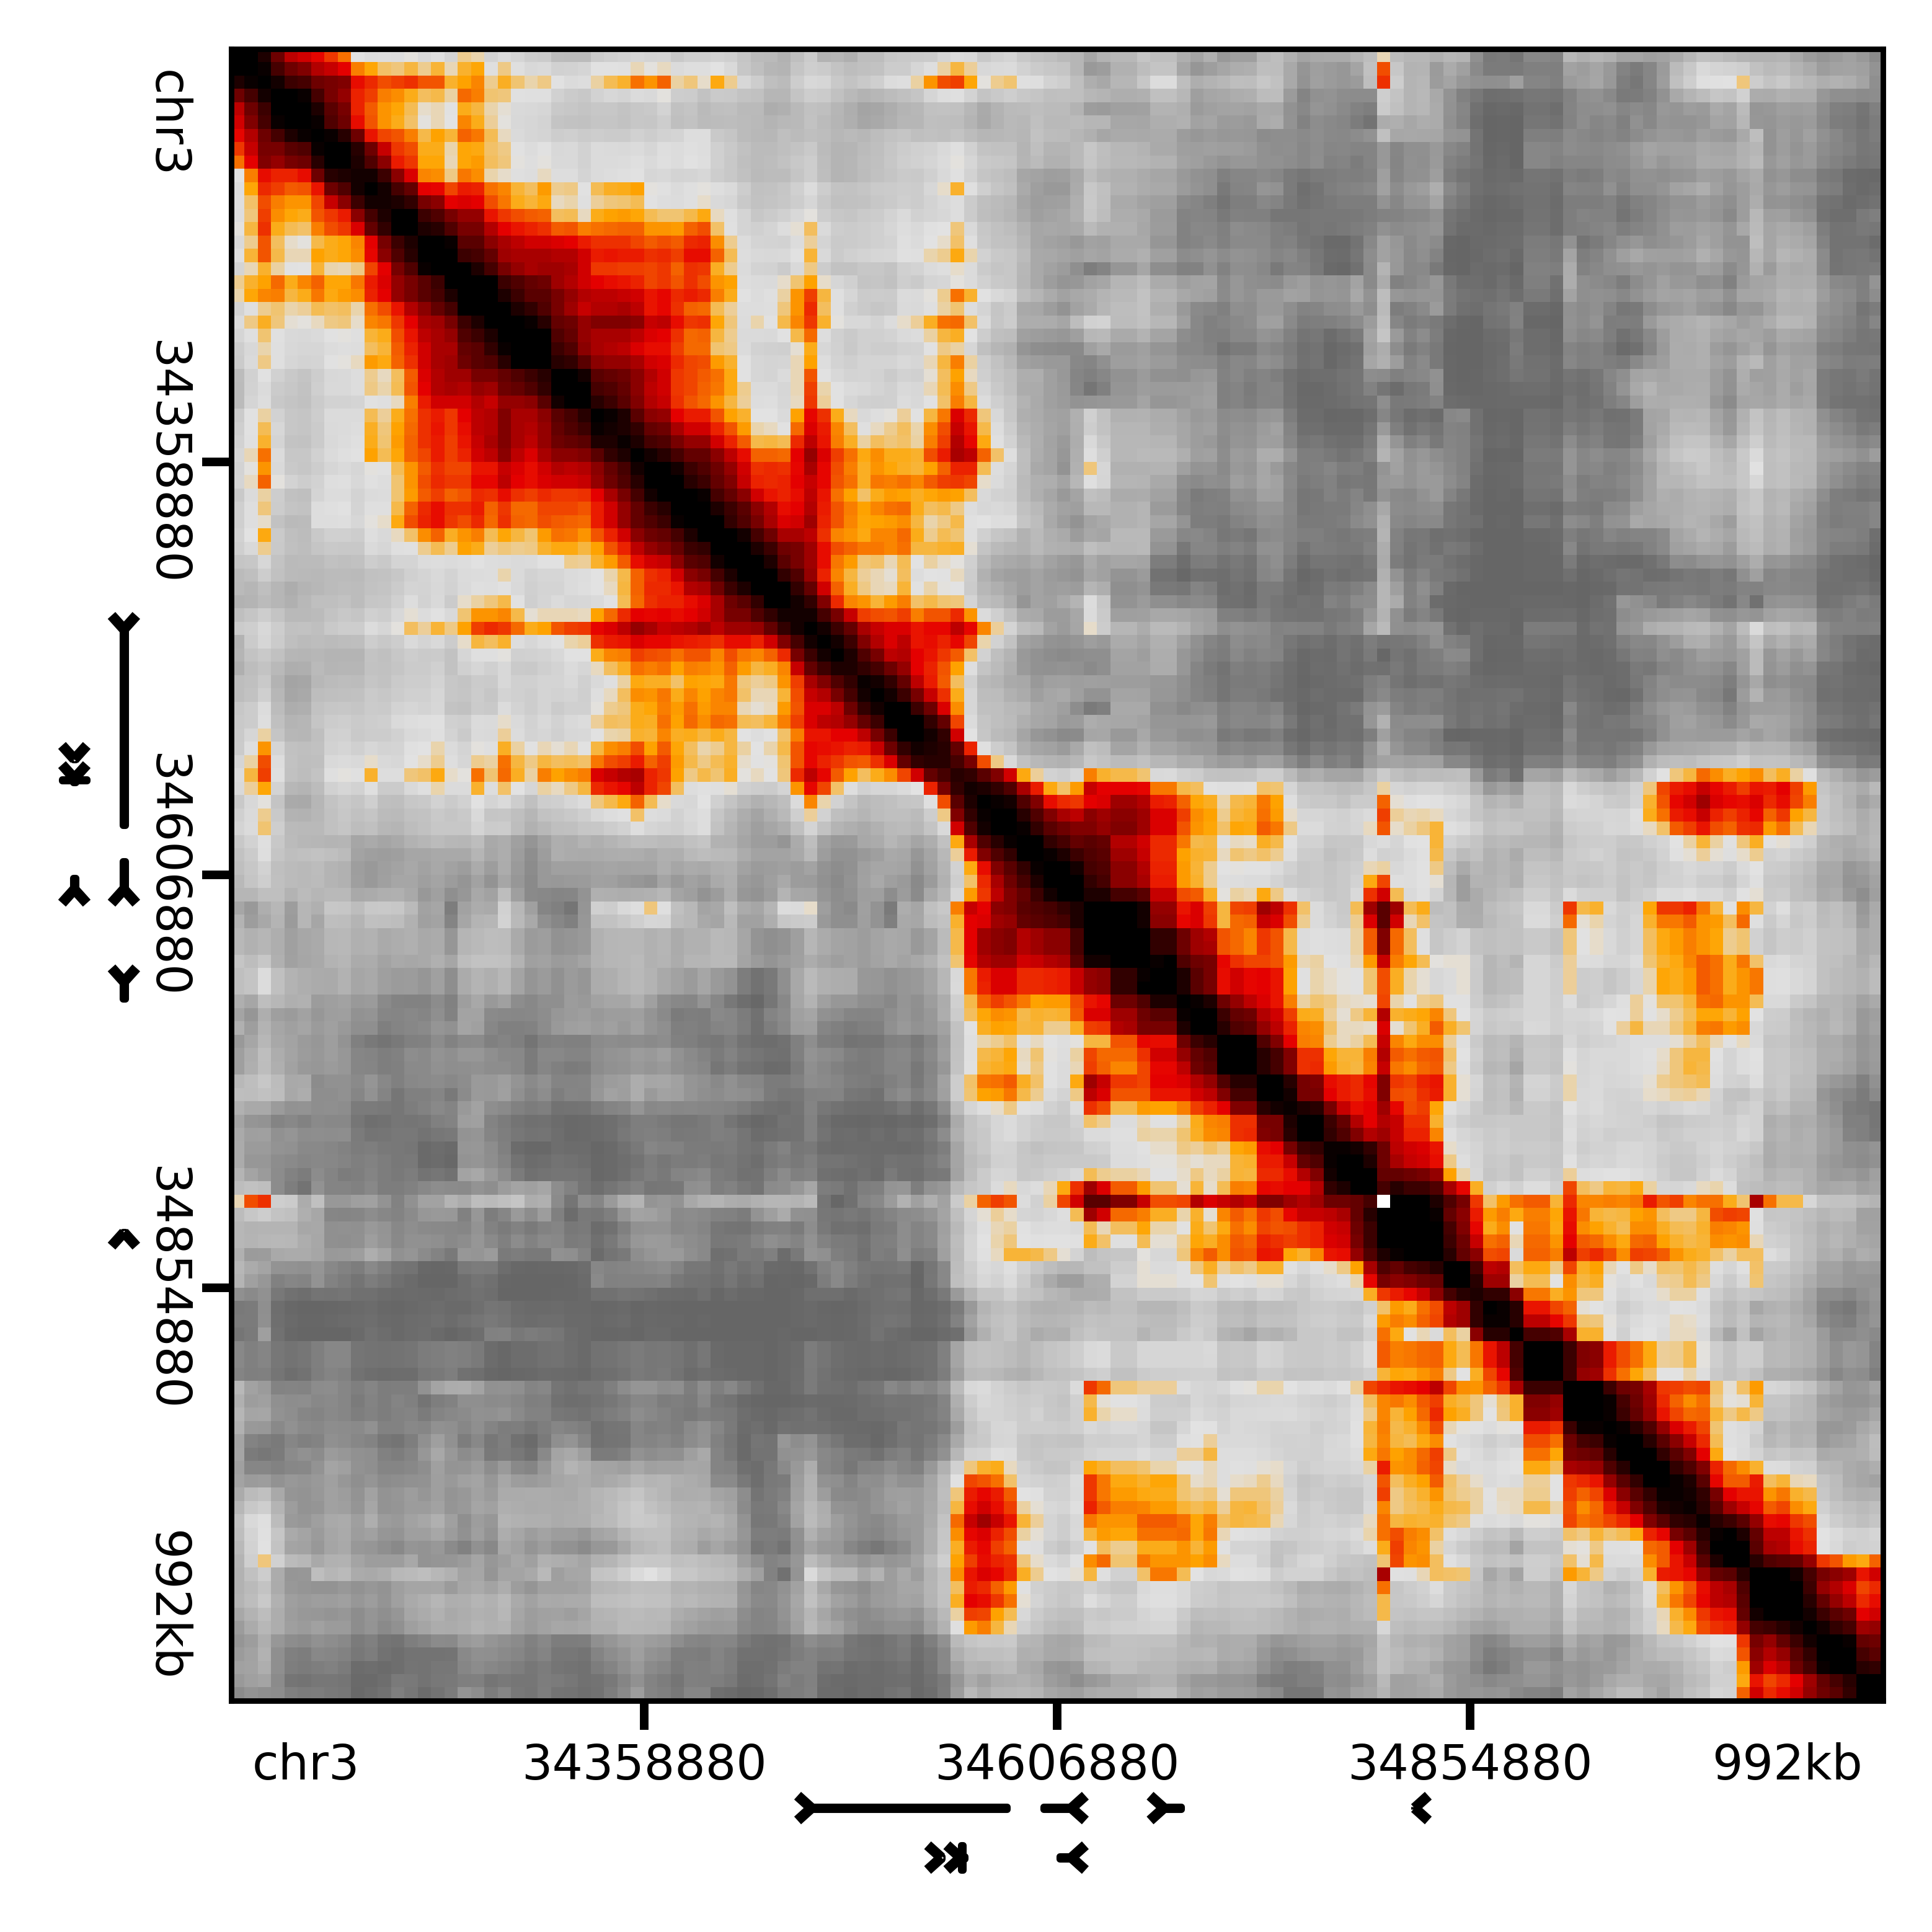

In [14]:
Image(filename='binned/pNPC_Rep2_Sox2.png', width=500)

Expected modeling
-----------------

In order to identify "enriched" interactions in our freshly-binned data, we
first need to answer the question: "Enriched with respect to what?" The answer
to this question is an expected model, which represents our understanding of
what we would expect the interaction frequency between any two bins to be. This
expected value depends both on the linear genomic separation between the bins,
as well as the effects of local contact domain structure.

We can generate an expected model by running

In [15]:
!lib5c expected -p bedfiles/8kb_bins.bed -RED binned/pNPC_Rep2.counts expected/pNPC_Rep2.counts

loading counts


using polynomial log-log 1-D distance model
using polynomial log-log 1-D distance model


applying donut correction
applying donut correction
creating directory expected


Note that for consistency, the flag used to specify the bin bedfile
`bedfiles/4kb_bins.bed` is still `-p`. Most `lib5c` subcommands work on
both fragment-level and bin-level data, with essentially no changes to the
parameters.

We are using the `-R/--regression`, `-E/--exclude_near_diagonal` and
`-D/--donut_correction` flags to indicate that we want to start with a
regional expected model fitted with a simple log-log regression which ignores
points too close to the diagonal, and then apply donut correction to account for
local variations in contact domain structure.

Variance modeling
-----------------

Armed with an expected model, we can now readily identify which pairs of bins
interact more frequently than expected. However, what we really want to know is
which pairs of bins interact *significantly* more frequently than expected. In
order to understand the extent of insignificant, noise-driven variations at each
point, we need to construct a variance model - a statistical variance estimate
for each pair of bins.

We can generate a variance model by running

In [16]:
!lib5c variance -p bedfiles/8kb_bins.bed binned/pNPC_Rep2.counts expected/pNPC_Rep2.counts variance/pNPC_Rep2.counts

loading counts


writing variance
creating directory variance


By default, this will fit a log-normal deviation-based distance-variance relationship to
the observed data.

P-value calling
---------------

Finally, we will call p-values for the interactions in our dataset

In [17]:
!lib5c pvalues -p bedfiles/8kb_bins.bed binned/pNPC_Rep2.counts expected/pNPC_Rep2.counts variance/pNPC_Rep2.counts -L norm pvalues/pNPC_Rep2.counts

loading counts


calling pvalues
writing p-values
creating directory pvalues


Calling p-values simply parametrizes a distribution of a specified family (here
we chose `-L norm` for the lognormal distribution) with mean value taken from
the expected model and variance taken from the variance model, and then calls a
right-tail p-value for the observed value in the binned data.

### P-value heatmaps


To visualize p-values, we can use the `lib5c plot heatmap` subcommand as
above, but we need to invoke it like

In [18]:
!lib5c plot heatmap -p bedfiles/8kb_bins.bed -r Sox2 -PR -g mm9 pvalues/pNPC_Rep2.counts pvalues/pNPC_Rep2_Sox2.png

loading counts


preparing to plot
plotting


Here we are using the `-P/--pvalue` flag to indicate that we are trying to
visualize p-values, the `-R/--rulers` flag to indicate that we want to add
genomic coordinate rulers to the heatmap, and the `-g/--genes` flag to
indicate that we want to add gene tracks from the mm9 reference genome.

The results should look something like this:

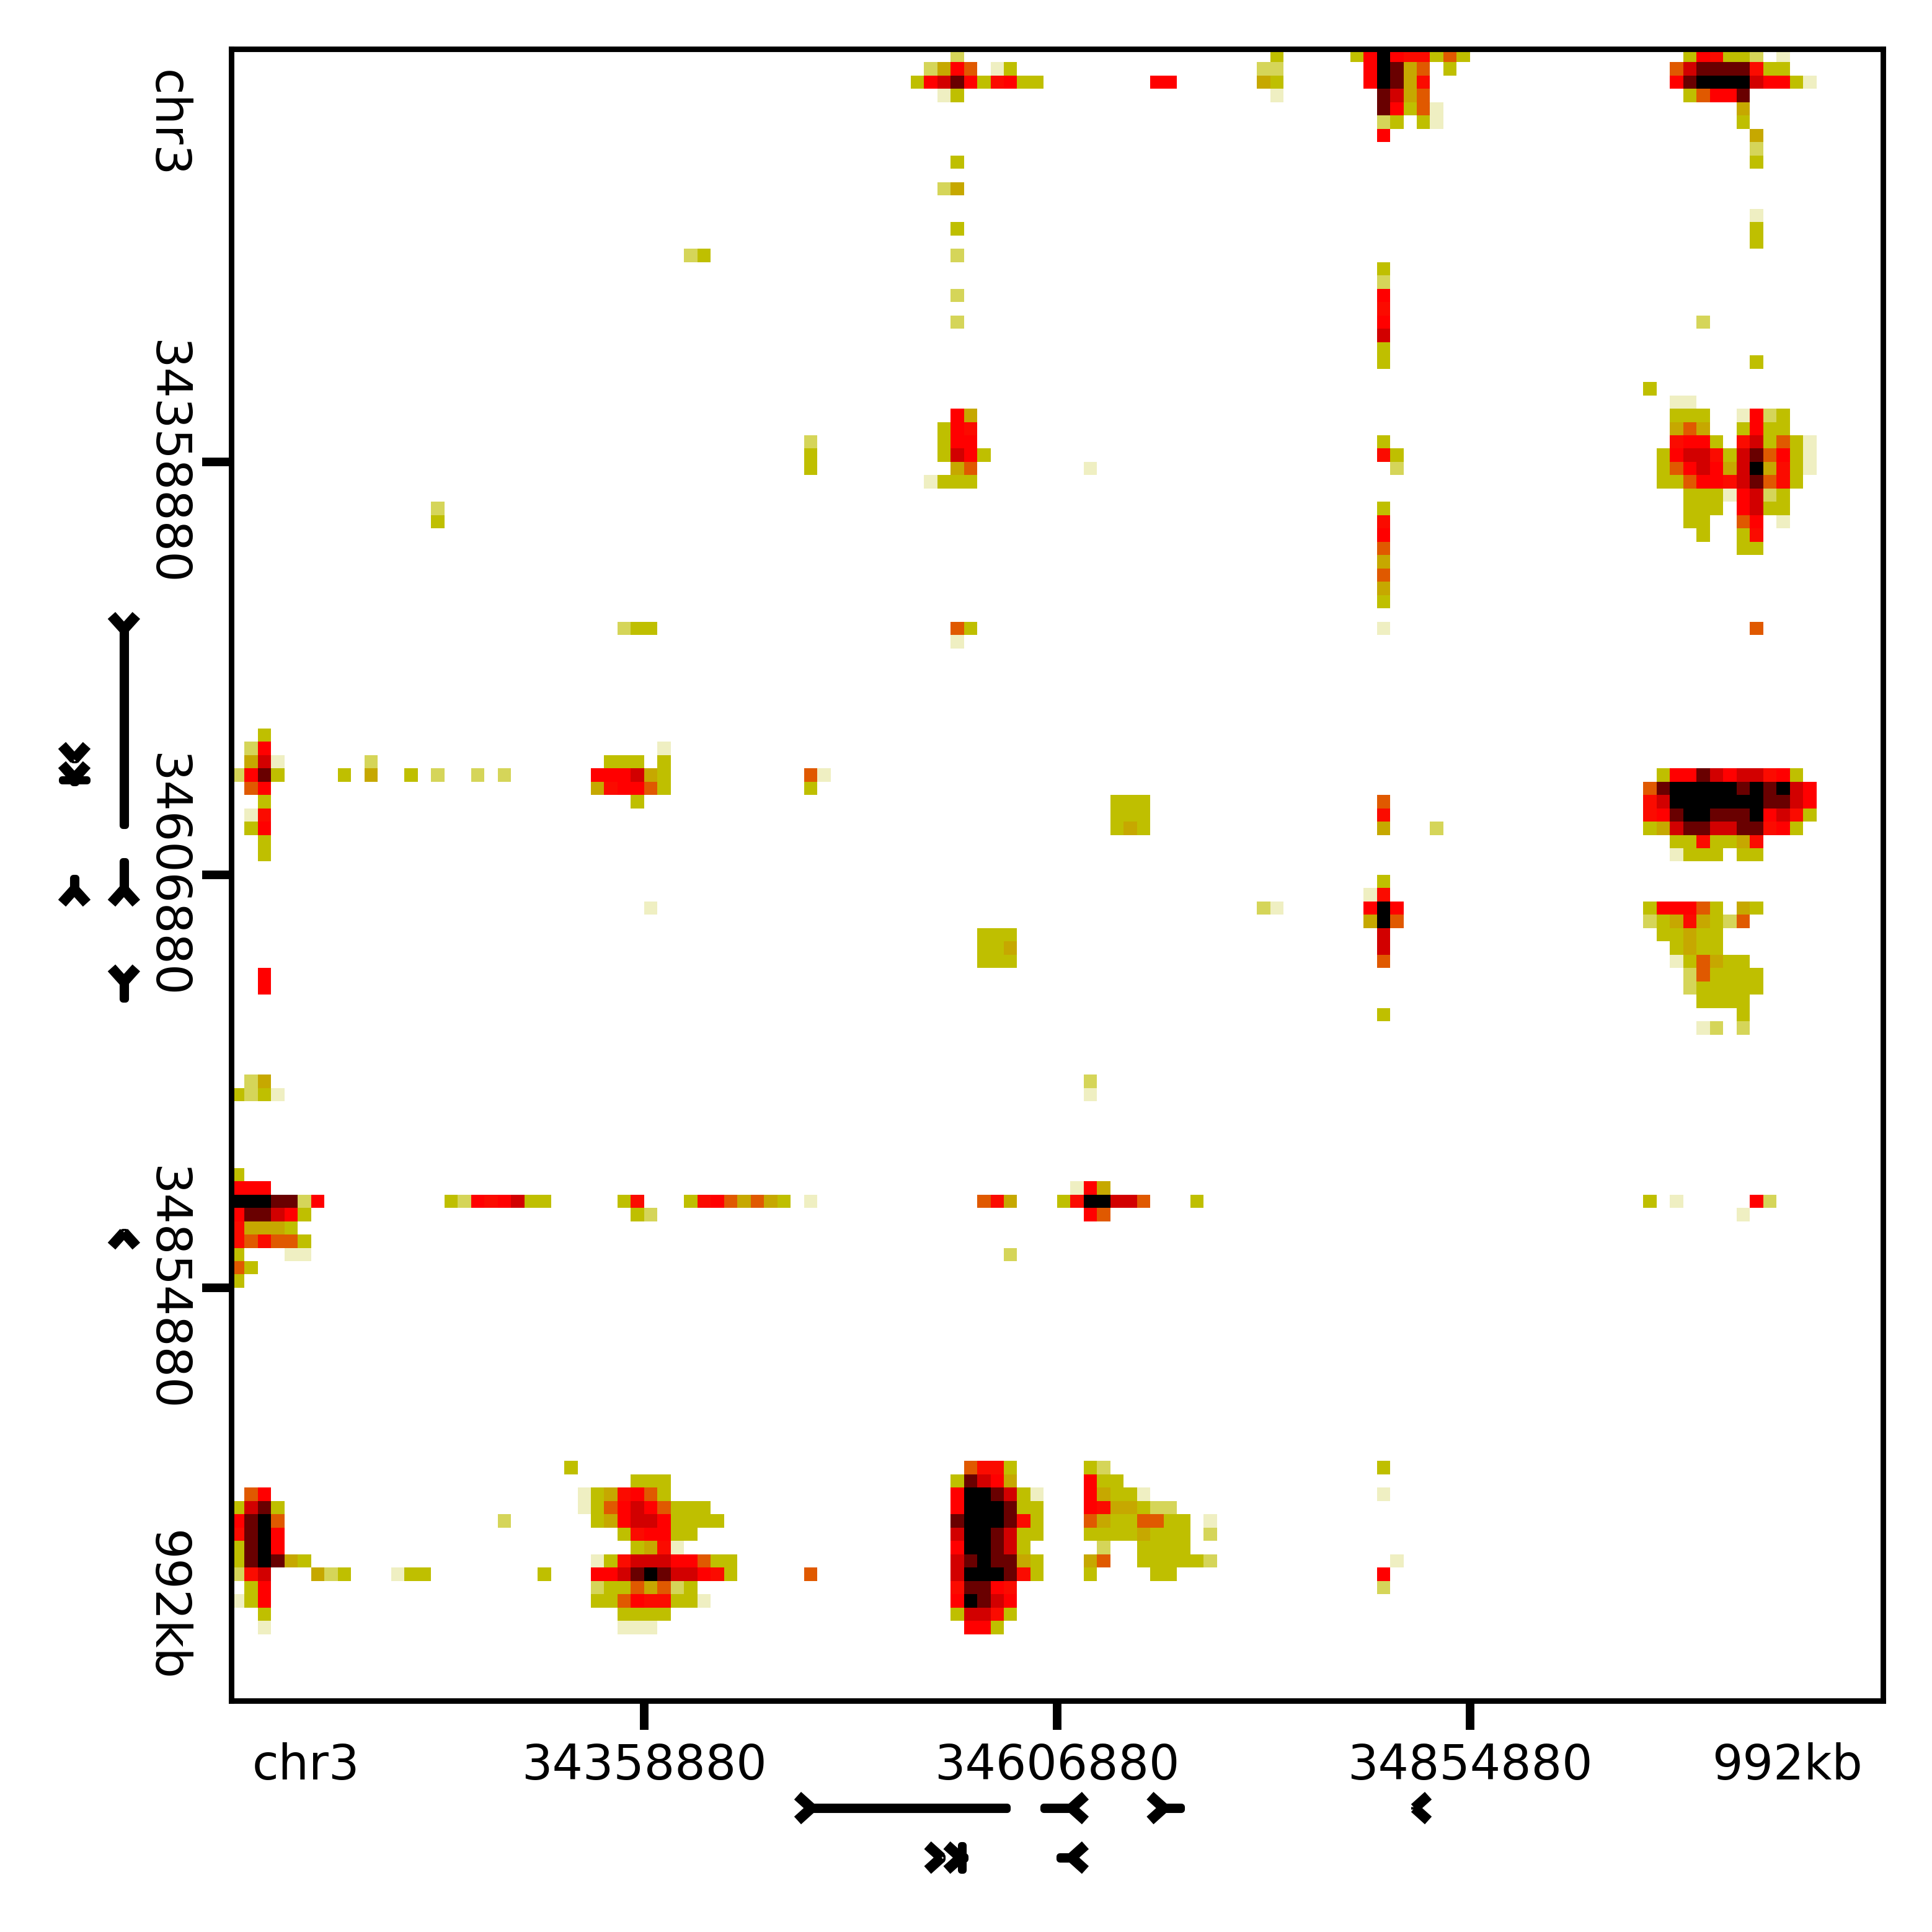

In [19]:
Image(filename='pvalues/pNPC_Rep2_Sox2.png', width=500)

Next steps
----------

Go ahead and explore the other `lib5c` subcommands! Remember that you can list
all the subcommands and get detailed help for a particular subcommand with the
`-h/--help` flag.